# Rede CNN 

## Dataset Respiratory_Sound_Database_Pneumo_Healthy_Only - Dataset 2 - no_augment_10

In [1]:
from datetime import datetime
from os import listdir
from os.path import isfile, join

import os
import librosa
import librosa.display
import glob

import numpy as np
import pandas as pd

from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Dense, Dropout, Conv2D, BatchNormalization, MaxPooling2D, GlobalAveragePooling2D, Input, Activation, Flatten
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import plot_model
from tensorflow.keras import regularizers
from tensorflow.keras import optimizers

from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from scipy.signal import spectrogram


from scipy import signal
import matplotlib.pyplot as plt
import seaborn as sns

from livelossplot import PlotLossesKeras

/home/lucas/anaconda3/envs/ic/lib/python3.7/site-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit
/home/lucas/anaconda3/envs/ic/lib/python3.7/site-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit


In [2]:
# Necessário na minha máquina. Estava ocorrendo um erro devido à GPU e esse código resolveu.
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [3]:
GROUP_TRAIN = 'no_augment_10'
GROUP_TEST = 'no_augment_10'
USE_TEST_AS_VALIDATION_DATA = False
DATASET = 'dataset_2'
DATASET_TRAIN = DATASET
DATASET_TEST = DATASET
DURATION = 10
SIZE = 1000
CSV_TRAIN = 'train2.csv'
CSV_TEST = 'test2.csv'
"""
CNN2model1
CNN2model1KernelL1
CNN3model1
CNN4model1
CNN4model1KernelL1
"""
TOPOLOGY = 'CNN4model1KernelL1'
MODEL_NAME = f'{TOPOLOGY}_{DATASET}_{GROUP_TRAIN}_val_is_test_{USE_TEST_AS_VALIDATION_DATA}'

In [4]:
train_file_paths = glob.glob(f'../datasets/{DATASET}/{GROUP_TRAIN}/train/**/*.wav', recursive=True)
train_file_names = [os.path.splitext(os.path.basename(p))[0] for p in train_file_paths]

test_file_paths = glob.glob(f'../datasets/{DATASET}/{GROUP_TEST}/test/**/*.wav', recursive=True)
test_file_names = [os.path.splitext(os.path.basename(p))[0] for p in test_file_paths]

In [5]:
train_p_id_in_file = [] # patient IDs corresponding to each file
test_p_id_in_file = [] # patient IDs corresponding to each file
for name in train_file_names:
    train_p_id_in_file.append(int(name[:3]))

for name in test_file_names:
    test_p_id_in_file.append(int(name[:3]))

train_p_id_in_file = np.array(train_p_id_in_file)
test_p_id_in_file = np.array(test_p_id_in_file) 

In [6]:
SPEC_SHAPE_HEIGTH = 221
SPEC_SHAPE_WIDTH = 996
CHANNELS = 1    


def log_specgram(audio, sample_rate, window_size=20,
                 step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = spectrogram(audio,
                                     fs=sample_rate,
                                     window='hann',
                                     nperseg=nperseg,
                                     noverlap=noverlap,
                                     detrend=False)
    return freqs, times, np.log(spec.astype(np.float32) + eps)


def save_spec_img(out, spec, fmt='png'):
    result = Image.fromarray((spec * 255.0).astype(np.uint8))
    result.save(out + '.' + fmt)
    

def spec_load_npy(path, remove_bad_file=True):
    try: 
        spc = np.load(path).reshape(SPEC_SHAPE_HEIGTH,
                                    SPEC_SHAPE_WIDTH,
                                    CHANNELS)
        spc = normalize(spc)
    except Exception as ex:
        if remove_bad_file:
            if not os.path.isfile(path):
                print(f'Removing file {path}: is not a file',
                      cur_frame=currentframe(), mtype='W')
            else:
                os.remove(path)
        return np.zeros(shape=(SPEC_SHAPE_HEIGTH, SPEC_SHAPE_WIDTH, CHANNELS))
    return spc


def spec_load_img(path, remove_bad_file=True):
    try: 
        spc = np.array(Image.open(path)).reshape(SPEC_SHAPE_HEIGTH,
                                                 SPEC_SHAPE_WIDTH,
                                                 CHANNELS)
        spc = normalize(spc)
    except Exception as ex:
        if remove_bad_file:
            if not os.path.isfile(path):
                print(f'Removing file {path}: is not a file',
                      cur_frame=currentframe(), mtype='W')
            else:
                os.remove(path)
        return np.zeros(shape=(SPEC_SHAPE_HEIGTH, SPEC_SHAPE_WIDTH, CHANNELS))
    return spc


def rgb2gray(rgb):
    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
    return gray


def scale(X, x_min, x_max):
    nom = (X-X.min(axis=0))*(x_max-x_min)
    denom = X.max(axis=0) - X.min(axis=0)
    denom[denom==0] = 1
    return x_min + nom/denom 


def wav_to_specdata(path,
                    normalize_pixels=True,
                    reshape_to_image=False,
                    duration=DURATION):
    b, sr = librosa.load(path, duration=duration)
    _, _, spc = log_specgram(b, sr)    
    spc = spc.astype('float32')
    spc = spc.reshape(SPEC_SHAPE_HEIGTH, SPEC_SHAPE_WIDTH)
    if reshape_to_image:
        spc = spc.reshape(SPEC_SHAPE_HEIGTH, SPEC_SHAPE_WIDTH, 1)
    if normalize_pixels:
        spc = scale(spc, 0, 1)
    return spc

In [7]:
max_pad_len = SIZE
features_path = f'features/{DATASET}{os.sep}{DURATION}'

os.makedirs(features_path, exist_ok=True)

def extract_features(file_name):
    feature_name = f'{os.path.splitext(os.path.basename(file_name))[0]}.npy'
    feature_path = os.path.join(features_path, feature_name)
    if (os.path.isfile(feature_path)):
        return np.load(feature_path)
    spec = wav_to_specdata(file_name, normalize_pixels=True)
    pad_width = max_pad_len - spec.shape[1]
    spec = np.pad(spec, pad_width=((0, 0), (0, pad_width)), mode='constant')
    np.save(feature_path, spec)
    return spec

In [8]:
#filepaths = [join(mypath, f) for f in filenames] # full paths of files

In [9]:
train_p_diag = pd.read_csv(f"../Respiratory_Sound_Database/Respiratory_Sound_Database_Pneumo_Healthy_Only/{CSV_TRAIN}", header=None) # patient diagnosis file
test_p_diag = pd.read_csv(f"../Respiratory_Sound_Database/Respiratory_Sound_Database_Pneumo_Healthy_Only/{CSV_TEST}", header=None) # patient diagnosis file

In [10]:
train_labels = np.array([train_p_diag[train_p_diag[0] == x][1].values[0] for x in train_p_id_in_file]) 
test_labels = np.array([test_p_diag[test_p_diag[0] == x][1].values[0] for x in test_p_id_in_file]) 

In [11]:
extract_features(train_file_paths[0]).shape

(221, 1000)

In [12]:
train_features = [] 
test_features = []

for file_name in train_file_paths:
    data = extract_features(file_name)
    train_features.append(data)

for file_name in test_file_paths:
    data = extract_features(file_name)
    test_features.append(data)

print('Finished feature extraction from ', (len(train_features)+len(train_features)), ' files')
train_features = np.array(train_features)
test_features = np.array(test_features)

Finished feature extraction from  112  files


In [13]:
np.unique(train_labels)

array(['Healthy', 'Pneumonia'], dtype='<U9')

In [14]:
unique_elements, counts_elements = np.unique(train_labels, return_counts=True)
print(np.asarray((unique_elements, counts_elements)))

unique_elements_test, counts_elements_test = np.unique(test_labels, return_counts=True)
print(np.asarray((unique_elements_test, counts_elements_test)))

[['Healthy' 'Pneumonia']
 ['32' '24']]
[['Healthy' 'Pneumonia']
 ['3' '13']]


__Balanceando dados__

In [15]:
def balance_data(X, labels):
    """Balances data duplicating some instances of the minority classes"""
    balX = None
    baly = None
    unique, counts = np.unique(labels, return_counts=True)
    max_inst = max(counts)
    # For every class duplicate the necessary amount
    for label in unique:
        data_of_label = []
        for x, y in zip(X, labels):
            if y == label:
                data_of_label.append(x)
        data_of_label = np.asarray(data_of_label)
        extra = data_of_label[np.random.choice(data_of_label.shape[0],
                                               max_inst,
                                               replace=True), :]
        if balX is not None:
            balX = np.stack((balX, extra), axis = 0) 
            baly = np.stack((baly, np.asarray([label for i in range(len(extra))])))
        else:
            balX = extra
            baly = np.asarray([label for i in range(len(extra))])
    balX = np.concatenate(balX)
    baly = np.concatenate(baly)
    return balX, baly

In [16]:
train_features, train_labels = balance_data(train_features, train_labels)
test_features, test_labels = balance_data(test_features, test_labels)

In [17]:
# One-hot encode labels
le = LabelEncoder()
le.fit(train_labels)
train_labels_cat = to_categorical(le.transform(train_labels)) 
test_labels_cat = to_categorical(le.transform(test_labels)) 

In [18]:
train_features.shape

(64, 221, 1000)

In [19]:
input_dim = train_features.shape[1]*train_features.shape[2]

In [20]:
train_features = np.reshape(train_features, (*train_features.shape,1)) 
print(train_features.shape, train_labels_cat.shape)
test_features = np.reshape(test_features, (*test_features.shape,1)) 
print(test_features.shape, test_labels_cat.shape)

(64, 221, 1000, 1) (64, 2)
(26, 221, 1000, 1) (26, 2)


In [21]:
x_test, y_test = test_features, test_labels_cat
x_train, y_train = train_features, train_labels_cat

In [22]:
if USE_TEST_AS_VALIDATION_DATA:
    x_val, y_val = x_test, y_test
else:
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, stratify=y_train, 
                                                      test_size=0.1, random_state = 42)

**CNN model architecture**

In [23]:
num_labels = train_labels_cat.shape[1]

num_rows = SPEC_SHAPE_HEIGTH
num_columns = SIZE
num_channels = 1

filter_size = 2

In [24]:
def CNN2model1():
    # Construct model 
    model = Sequential()
    model.add(Conv2D(filters=32, kernel_size=filter_size, 
                     input_shape=(num_rows, num_columns, num_channels), activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Dropout(0.4))

    model.add(Conv2D(filters=16, kernel_size=filter_size, activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Dropout(0.4))

    model.add(Conv2D(filters=8, kernel_size=filter_size, activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Dropout(0.4))

    model.add(Conv2D(filters=4, kernel_size=filter_size, activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Dropout(0.4))

    model.add(GlobalAveragePooling2D())

    model.add(Dense(num_labels, activation='softmax')) 
    return model

In [25]:
def CNN2model1KernelL1():
    # Construct model 
    model = Sequential()
    model.add(Conv2D(filters=32, kernel_size=filter_size, 
                     input_shape=(num_rows, num_columns, num_channels), kernel_regularizer=tf.keras.regularizers.l1(0.001), activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Dropout(0.1))

    model.add(Conv2D(filters=16, kernel_size=filter_size, kernel_regularizer=tf.keras.regularizers.l1(0.001), activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Dropout(0.1))

    model.add(Conv2D(filters=8, kernel_size=filter_size, kernel_regularizer=tf.keras.regularizers.l1(0.001),  activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Dropout(0.1))

    model.add(Conv2D(filters=4, kernel_size=filter_size, kernel_regularizer=tf.keras.regularizers.l1(0.001),  activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Dropout(0.1))

    model.add(GlobalAveragePooling2D())

    model.add(Dense(num_labels, activation='softmax')) 
    return model

In [26]:
def CNN3model1():
    nb_filters = 32  # number of convolutional filters to use
    pool_size = (2, 2)  # size of pooling area for max pooling
    kernel_size = (3, 3)  # convolution kernel size
    nb_layers = 3
    input_shape = (num_rows, num_columns, num_channels)

    model = Sequential()
    model.add(Conv2D(nb_filters, kernel_size[0], kernel_size[1],
                        padding='valid', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    for layer in range(nb_layers-1):
        model.add(Conv2D(nb_filters, kernel_size[0], kernel_size[1]))
        model.add(BatchNormalization())
        model.add(Activation('elu'))
        model.add(MaxPooling2D(pool_size=pool_size))
        model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(128))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_labels))
    model.add(Activation("softmax"))
    return model

In [27]:
def CNN4model1():
    input_data = Input(shape=(num_rows, num_columns, num_channels))
    x = Conv2D(
        filters=50,
        kernel_size=3,
        activation='relu',
        data_format='channels_last'
    )(input_data)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(0.2)(x)

    x = Conv2D(
        filters=50,
        kernel_size=3,
        activation='relu'
    )(x)
    x = Conv2D(
        filters=50,
        kernel_size=3,
        activation='relu'
    )(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(0.2)(x)

    x = Conv2D(
        filters=64,
        kernel_size=3,
        activation='relu'
    )(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(0.2)(x)

    x = Conv2D(
        filters=128,
        kernel_size=3,
        activation='relu'
    )(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(0.2)(x)

    x = GlobalAveragePooling2D()(x)

    x = Dense(num_labels, activation='softmax')(x)
    model = Model(input_data, x)
    return model

In [28]:
def CNN4model1KernelL1():
    input_data = Input(shape=(num_rows, num_columns, num_channels))
    x = Conv2D(
        filters=50,
        kernel_size=3,
        kernel_regularizer=tf.keras.regularizers.l1(0.00025),
        activation='relu',
        data_format='channels_last'
    )(input_data)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(0.2)(x)

    x = Conv2D(
        filters=50,
        kernel_size=3,
        kernel_regularizer=tf.keras.regularizers.l1(0.00025),
        activation='relu'
    )(x)
    x = Conv2D(
        filters=50,
        kernel_size=3,
        kernel_regularizer=tf.keras.regularizers.l1(0.00025),
        activation='relu'
    )(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(0.2)(x)

    x = Conv2D(
        filters=64,
        kernel_size=3,
        kernel_regularizer=tf.keras.regularizers.l1(0.00025),
        activation='relu'
    )(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(0.2)(x)

    x = Conv2D(
        filters=128,
        kernel_size=3,
        kernel_regularizer=tf.keras.regularizers.l1(0.00025),
        activation='relu'
    )(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(0.2)(x)

    x = GlobalAveragePooling2D()(x)

    x = Dense(num_labels, activation='softmax')(x)
    model = Model(input_data, x)
    return model

In [29]:
num_labels = train_labels_cat.shape[1]
model = globals()[TOPOLOGY]()

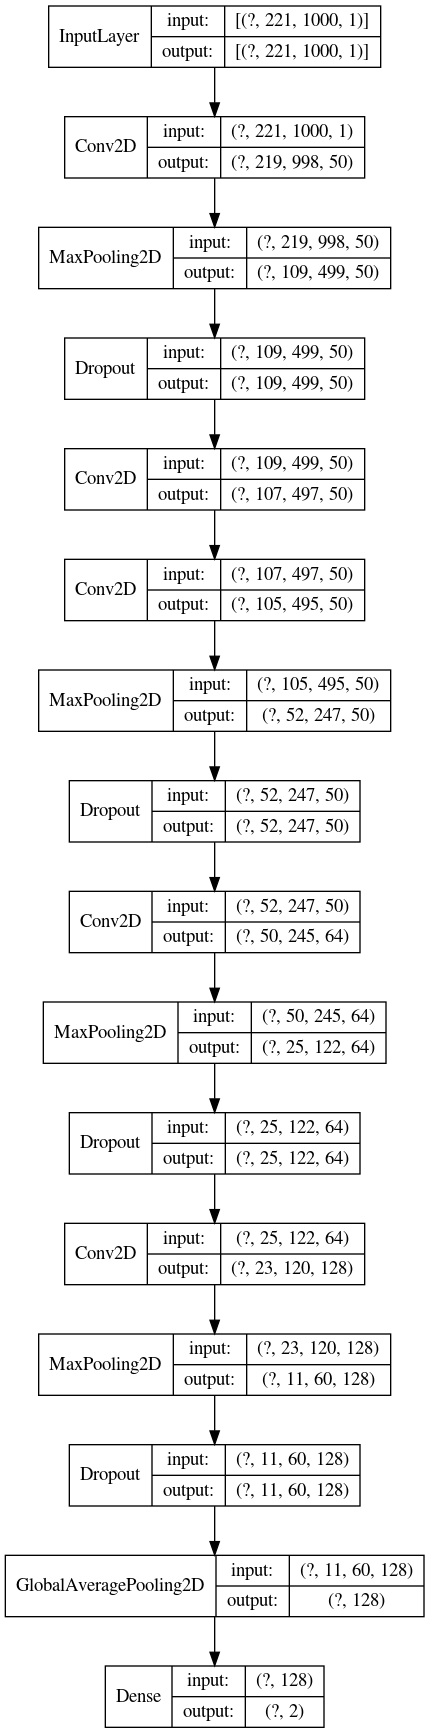

In [30]:
os.makedirs('topologias', exist_ok=True)
plot_model(model, to_file=f'topologias{os.sep}{MODEL_NAME}.png',
           show_shapes=True, show_layer_names=False)

In [31]:
# Compile the model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam') 

In [32]:
# Display model architecture summary 
model.summary()

# Calculate pre-training accuracy 
score = model.evaluate(x_test, y_test, verbose=1)
accuracy = 100*score[1]

print("Pre-training accuracy: %.4f%%" % accuracy)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 221, 1000, 1)]    0         
_________________________________________________________________
conv2d (Conv2D)              (None, 219, 998, 50)      500       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 109, 499, 50)      0         
_________________________________________________________________
dropout (Dropout)            (None, 109, 499, 50)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 107, 497, 50)      22550     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 105, 495, 50)      22550     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 52, 247, 50)       0     

**Training**

Here we will train the model. If we have a trained model, we can load it instead from the next cell.

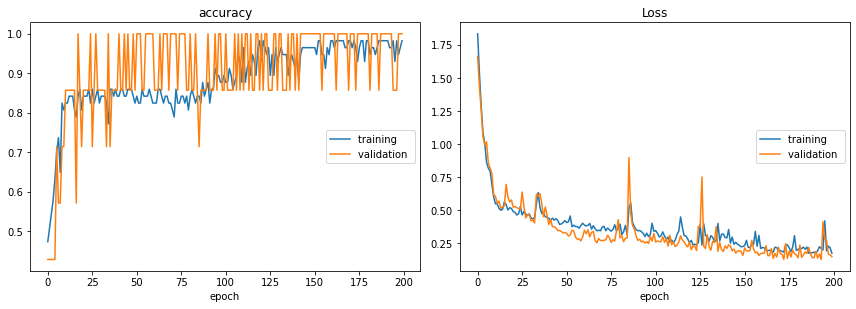

accuracy
	training         	 (min:    0.474, max:    0.982, cur:    0.982)
	validation       	 (min:    0.429, max:    1.000, cur:    1.000)
Loss
	training         	 (min:    0.174, max:    1.833, cur:    0.174)
	validation       	 (min:    0.127, max:    1.663, cur:    0.149)
57/57 [==============================] - 2s 31ms/sample - loss: 0.1738 - accuracy: 0.9825 - val_loss: 0.1487 - val_accuracy: 1.0000
Training completed in time:  0:06:08.456979


In [33]:
# train model
num_epochs = 200
num_batch_size = 6
checkpoint_filepath = f'models/{MODEL_NAME}.h5'

os.makedirs('models', exist_ok=True)
callbacks = [
    PlotLossesKeras(),
    ModelCheckpoint(
        filepath=checkpoint_filepath,
        # Path where to save the model
        # The two parameters below mean that we will overwrite
        # the current checkpoint if and only if
        # the `val_accuracy` score has improved.
        save_best_only=True,
        monitor='val_accuracy',
        verbose=0)
]
start = datetime.now()

history = model.fit(x_train, y_train, batch_size=num_batch_size, epochs=num_epochs,
                    validation_data=(x_val, y_val), callbacks=callbacks, verbose=1)


duration = datetime.now() - start
print("Training completed in time: ", duration)

## Teste (melhor modelo)

In [34]:
model = load_model(checkpoint_filepath)
score = model.evaluate(x_train, y_train, verbose=0)
train_loss, train_acc = score[0], score[1]
print("Training Accuracy: ", score[1])

score = model.evaluate(x_test, y_test, verbose=0)
test_loss, test_acc = score[0], score[1]
print("Testing Accuracy: ", score[1])

Training Accuracy:  0.8596491
Testing Accuracy:  0.88461536


**Plot accuracies and losses**

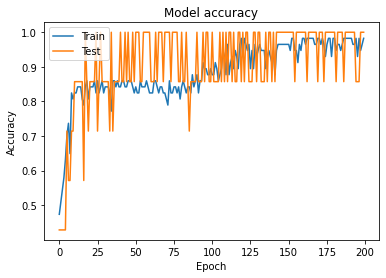

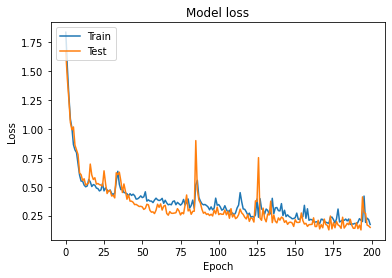

In [35]:
os.makedirs('graficos', exist_ok=True)
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig(f'graficos{os.sep}{MODEL_NAME}_accuracy_{train_acc}_{test_acc}.png')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig(f'graficos{os.sep}{MODEL_NAME}_loss_{train_loss}_{test_loss}.png')
plt.show()

In [36]:
preds = model.predict(x_test) # label scores 

classpreds = np.argmax(preds, axis=1) # predicted classes 

y_testclass = np.argmax(y_test, axis=1) # true classes

n_classes=2 # number of classes

In [37]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], preds[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [38]:
c_names = ['Bronchiectasis', 'Bronchiolitis', 'COPD', 'Healthy', 'Pneumonia', 'URTI']
c_names = ['Healthy', 'Pneumonia']

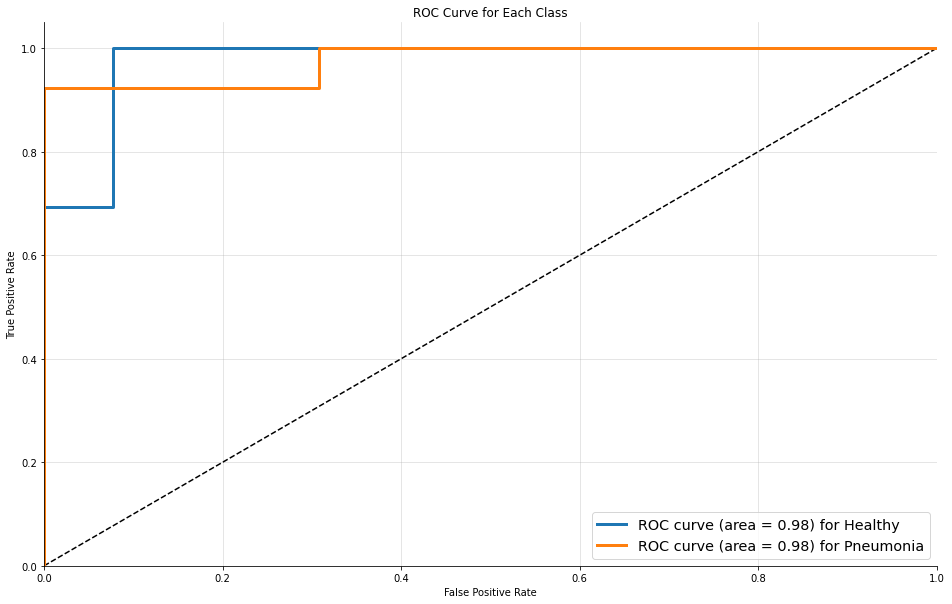

In [39]:
# Plot ROC curves
fig, ax = plt.subplots(figsize=(16, 10))
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curve for Each Class')
for i in range(n_classes):
    ax.plot(fpr[i], tpr[i], linewidth=3, label='ROC curve (area = %0.2f) for %s' % (roc_auc[i], c_names[i]))
ax.legend(loc="best", fontsize='x-large')
ax.grid(alpha=.4)
sns.despine()
plt.show()

In [40]:
# Classification Report
print(classification_report(y_testclass, classpreds, target_names=c_names))

              precision    recall  f1-score   support

     Healthy       0.81      1.00      0.90        13
   Pneumonia       1.00      0.77      0.87        13

    accuracy                           0.88        26
   macro avg       0.91      0.88      0.88        26
weighted avg       0.91      0.88      0.88        26



In [41]:
# Confusion Matrix
print(confusion_matrix(y_testclass, classpreds))

[[13  0]
 [ 3 10]]


In [42]:
import itertools
def plot_confusion_matrix(cm, unique_labels, show=True, output=None,
                          title='Confusion matrix', cmap=plt.cm.Oranges):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(cm.shape[1])
    plt.xticks(tick_marks, rotation=45)
    ax = plt.gca()
    ax.set_xticklabels((ax.get_xticks() + 1).astype(str))
    plt.yticks(tick_marks)

    ax.set_xticklabels(unique_labels)
    ax.set_yticklabels(unique_labels)

    thresh = cm.max() / 1.4
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], '.1f'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    if output is not None:
        plt.savefig(output)
    if show:
        plt.show()
    plt.close()
    return output


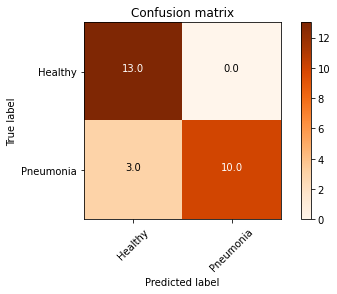

'cm/CNN4model1KernelL1_dataset_2_no_augment_10_val_is_test_False_0.859649121761322_0.8846153616905212.png'

In [43]:
os.makedirs('cm', exist_ok=True)
plot_confusion_matrix(confusion_matrix(y_testclass, classpreds), unique_labels=["Healthy", "Pneumonia"],
                      output=os.path.join('cm', f'{MODEL_NAME}_{train_acc}_{test_acc}.png'))

__Write csv__

In [44]:
with open('report.csv', 'a') as report:
    report.write(f'{MODEL_NAME},{TOPOLOGY},{DATASET},{GROUP_TRAIN},{DURATION},{USE_TEST_AS_VALIDATION_DATA},{train_acc},{test_acc}\n')